# Gold extraction of the ore

The task is to prepare a prototype machine learning model for a company, that develops solutions for the industrial enterprises.

The model should predict the recovery rate of gold from the gold ore. The data includes mining and cleaning parameters.

The model will help optimize production in order to launch an enterprise with profitable characteristics.

The sequence of subtasks:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

To solve the problem, a new quality metric will be introduced - `sMAPE` (Symmetric Mean Absolute Percentage Error).
It is similar to `MAE`, but is expressed  in relative terms, not absolute. Symmetrical, as it equally takes into account the scale of both the target feature and the prediction.

The formula for final SMAPE is provided by the Client and considers error in two stages of the gold extraction process:
**rougher stage** and **final stage**:

`Total sMAPE = 25% rougher sMAPE + 75% final sMAPE`

## 1. Data preparation

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
#1.1
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
dfs = [df_train, df_test, df_full]
for df in dfs:
    df.info()
    print()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


The initial inspection has shown that the test dataset contains fewer features (columns) than the train one. It will be necessary to use this particular set of features, when training and testing the model,.

The data contains gaps. Due to the pecularities of the technical process, the parameters measured close in time are often similar. Thus, it is recommended to fill in the gaps with the value from the row above (performed at step 1.4).

Data types (except for `date` (index)) - fractional numbers (float). No data type conversions are needed.

In [3]:
#1.2
F_train = df_train['rougher.input.feed_au']
C_train = df_train['rougher.output.concentrate_au']
T_train = df_train['rougher.output.tail_au']
rougher_output_recovery_train = ((C_train*(F_train-T_train))/(F_train*(C_train-T_train)))*100

target_train = df_train['rougher.output.recovery']
mae = mean_absolute_error(target_train, rougher_output_recovery_train)
print(f"MAE for Flotation Enrichment Efficiency: {mae:,.4f}.")

MAE for Flotation Enrichment Efficiency: 0.0000.


Above there is a check of the correctness of the formula for calculating the efficiency of the crude concentrate enrichment. The check showed that the efficiency is calculated by the system correctly, as the mean absolute error `MAE` equals to zero.

In [4]:
#1.3
print("Columns train:", df_train.shape[1], "Columns test:", df_test.shape[1])
columns = list(df_train.columns) + list(df_test.columns)
columns = pd.Series(columns)
columns_count = pd.DataFrame(columns.value_counts())
columns_to_delete = columns_count[columns_count[0]==1]
columns_to_delete

Columns train: 87 Columns test: 53


,0
primary_cleaner.output.concentrate_au,1
final.output.recovery,1
final.output.concentrate_sol,1
rougher.output.tail_ag,1
primary_cleaner.output.concentrate_sol,1
primary_cleaner.output.concentrate_pb,1
final.output.concentrate_ag,1
rougher.calculation.floatbank10_sulfate_to_au_feed,1
final.output.tail_sol,1
rougher.output.concentrate_au,1


Features not available on the test sample are the features calculated during the gold mining process (not the primary ore features).

Among these features the critical ones are the target features: `final.output.recovery`,`rougher.output.recovery`. To test the model, it is necessary to map them to the test data (done in the next step).

In [5]:
#1.4
merger = df_full.loc[:,['final.output.recovery','rougher.output.recovery', 'date']] 
df_test = df_test.merge(merger, on='date', how='left') #add target columns to the test sample
df_test.shape

(5290, 55)

In [6]:
df_train.fillna(method='ffill', inplace = True) #gaps ffill
df_test.fillna(method='ffill', inplace = True)

In [7]:
columns_to_delete_list = list(columns_to_delete.index.values) #columns to delete - irrelevant for the model
len(columns_to_delete_list) #check sample size (87-53 = 34)

34

### Conclusion

The first step was dedicated to the preliminary analysis and data processing. Columns not included to the test data were identified and will be deleted during the step 3. The correctness of the calculation of the enrichment efficiency formula `rougher.output.recovery` was also checked.

## 2. Exploratory data analysis (EDA)

In [8]:
#2.1
metalls_columns = ['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au','rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag','rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']
metalls_mean = []
metalls_median = []
for column in metalls_columns:
    mean = df_train[column].mean()
    metalls_mean.append(mean)
    
    median = df_train[column].median()
    metalls_median.append(median)

display(metalls_mean) 
print(pd.Series(metalls_mean) - pd.Series(metalls_median)) #print the diff mean and median for the metrics selection

[7.866576841919407,
 19.43995785143646,
 32.386835978391346,
 44.00379162105571,
 8.579195196596277,
 11.775812314356036,
 8.200915815165981,
 5.141920924857091,
 3.5054646776095564,
 7.664554751481546,
 9.568544006770484,
 10.132847758146394]

0     0.217439
1    -0.507355
2    -0.838999
3    -0.868644
4     0.423104
5     0.028450
6    -0.025332
7     0.147314
8     0.091197
9    -0.095881
10   -0.352054
11   -0.164165
dtype: float64


<AxesSubplot:>

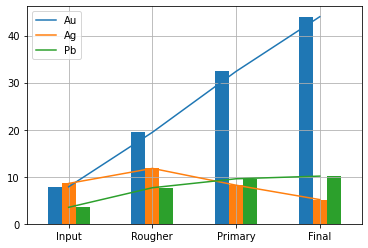

In [9]:
data_graph_mean = {'Au': [7.866577, 19.439958, 32.386836, 44.003792], 
              'Ag': [8.579195, 11.775812, 8.200916, 5.141921], 
        'Pb': [3.505465, 7.664555, 9.568544, 10.132848]
        } #add data to the table for the graphic interpretation
data_graph_mean = pd.DataFrame(data_graph_mean, index=['Input', 'Rougher', 'Primary', 'Final'])
ax_1=data_graph_mean.plot(kind='bar')
data_graph_mean.plot(ax=ax_1, legend=False, grid=True)

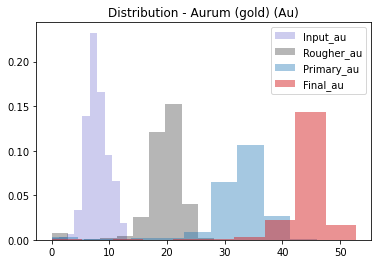

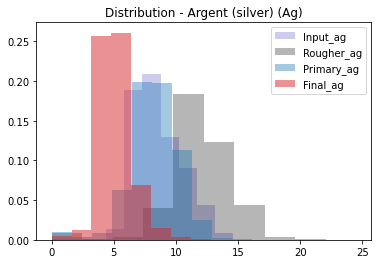

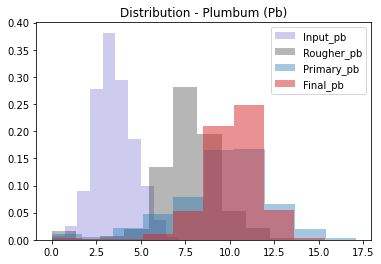

In [10]:
#histograms

plt.hist(df_train['rougher.input.feed_au'], color='#0504aa', density = True, alpha=0.2, label='Input_au')
plt.hist(df_train['rougher.output.concentrate_au'], color='#0f0f0f', density = True, alpha=0.3, label='Rougher_au')
plt.hist(df_train['primary_cleaner.output.concentrate_au'], color='#1f77b4', density = True, alpha=0.4, label='Primary_au')
plt.hist(df_train['final.output.concentrate_au'], color='#d62728', density = True, alpha=0.5, label='Final_au')
plt.legend(loc='upper right')
plt.title('Distribution - Aurum (gold) (Au)')
plt.show()

plt.hist(df_train['rougher.input.feed_ag'], color='#0504aa', density = True, alpha=0.2, label='Input_ag')
plt.hist(df_train['rougher.output.concentrate_ag'], color='#0f0f0f', density = True, alpha=0.3, label='Rougher_ag')
plt.hist(df_train['primary_cleaner.output.concentrate_ag'], color='#1f77b4', density = True, alpha=0.4, label='Primary_ag')
plt.hist(df_train['final.output.concentrate_ag'], color='#d62728', density = True, alpha=0.5, label='Final_ag')
plt.legend(loc='upper right')
plt.title('Distribution - Argent (silver) (Ag)')
plt.show()

plt.hist(df_train['rougher.input.feed_pb'], color='#0504aa', density = True, alpha=0.2, label='Input_pb')
plt.hist(df_train['rougher.output.concentrate_pb'], color='#0f0f0f', density = True, alpha=0.3, label='Rougher_pb')
plt.hist(df_train['primary_cleaner.output.concentrate_pb'], color='#1f77b4', density = True, alpha=0.4, label='Primary_pb')
plt.hist(df_train['final.output.concentrate_pb'], color='#d62728', density = True, alpha=0.5, label='Final_pb')
plt.legend(loc='upper right')
plt.title('Distribution - Plumbum (Pb)')
plt.show()

To analyze the change in the concentration of metals (Au - gold, Ag - silver, Pb - plumbum) at the various stages of purification, it was decided to look at the average and also the distribution. The median does not differ much from the average, thus only one is taken for the analytics.
On average, the concentration of metals in the course of purification increases, while, as expected, the largest increase is observed for the gold - from 8% to 44%.

The silver concentration decreases after the flotation stage - the final concentration is 5% against the initial 8.5%. The plumbum concentration increases, at the same time the increase is insignificant after the flotation step. The initial figure of 3.5% grows up to 10%.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rougher.input.feed_size', ylabel='Density'>

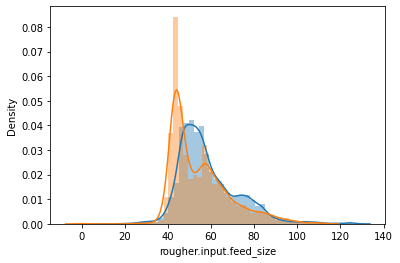

In [11]:
#2.2
sn.distplot(df_train['rougher.input.feed_size'][df_train['rougher.input.feed_size']<df_train['rougher.input.feed_size'].quantile(0.99)])
sn.distplot(df_test['rougher.input.feed_size'][df_test['rougher.input.feed_size']<df_test['rougher.input.feed_size'].quantile(0.99)])

To plot the distribution, maximum values were discarded in order to prevent distortion (non-representative representation) of the plots (analysis of 99% of samples).

Comparison of the distribution of raw material granule sizes in the training and test samples showed that the distribution in both follows the same trend: a normal distribution with two peaks. This distribution suggests that there may be 2 groups of granule types in the samples: medium-sized and larger than average. The peaks are more noticeable in the test sample, which is logical due to the smaller sample size.

Thus, the distributions do not differ much from each other, which means we can start building and evaluating the model.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:>

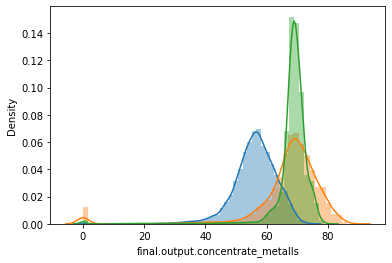

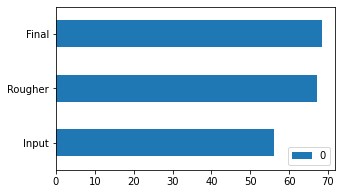

In [12]:
#2.3
df_train['rougher.input.concentrate_metalls'] = df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_pb']+df_train['rougher.input.feed_au']+df_train['rougher.input.feed_sol'] 
df_train['rougher.output.concentrate_metalls'] = df_train['rougher.output.concentrate_ag']+df_train['rougher.output.concentrate_pb']+df_train['rougher.output.concentrate_au']+df_train['rougher.output.concentrate_sol'] 
df_train['final.output.concentrate_metalls'] = df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']+df_train['final.output.concentrate_au']+df_train['final.output.concentrate_sol'] 

line = {0: [df_train['rougher.input.concentrate_metalls'].mean(),df_train['rougher.output.concentrate_metalls'].mean(), df_train['final.output.concentrate_metalls'].mean()]}
data_totall_metalls=pd.DataFrame(line, index=['Input', 'Rougher', 'Final'])

sn.distplot(df_train['rougher.input.concentrate_metalls'])
sn.distplot(df_train['rougher.output.concentrate_metalls'])
sn.distplot(df_train['final.output.concentrate_metalls'])
data_totall_metalls.plot(kind='barh', figsize=[5,3])

The graphs show the total concentration of all substances (including salts) at different stages: in raw materials, in crude and final concentrates and its distribution. The total concentration grows, while the growth slows down at the change of stage from the crude to the final (average concentrations are very close). The graph also showed that the samples contained data with zero concentrations of metals and salts - perhaps the data was not recorded or the instrument was unable to sample. The distribution of concentration at the final stage on the graph is represented by a curve with the highest "hill" - which makes sense, as during the technological process a more similar final concentration of substances in all positions is achieved on average.

### Conclusion

The second step was dedicated to EDA. During the analysis, it was found out that the concentration of gold increases multiplely during the process. A comparison was also made of the sizes of raw material granules in the samples, which showed that the granules in both samples (train - test) are similar in size. The total concentration of all substances at different stages is growing systematically, while the growth is more noticeable from the stage of raw materials to crude concentrate and differs less strongly at the final stage. 

## 3. Model

In [13]:
#3.1
def smape(target, predictions):
    smape_sum = (abs(target-predictions)/((abs(target)+abs(predictions))/2)).sum()
    return 1/len(target)*smape_sum

The `smape` function was written above - a metric for further evaluation of the model.

In [14]:
#3.2
print(df_test[df_test['rougher.output.recovery']==0]['date'].count())
df_test[df_test['final.output.recovery']==0]['date'].count()

97


40

In [15]:
df_train = df_train[df_train['rougher.output.recovery']!=0]
print(df_train.shape)
df_train = df_train[df_train['final.output.recovery']!=0]
print(df_train.shape)

df_test = df_test[df_test['rougher.output.recovery']!=0]
print(df_test.shape)
df_test = df_test[df_test['final.output.recovery']!=0]
print(df_test.shape)

(13852, 90)
(13795, 90)
(5193, 55)
(5154, 55)


In [16]:
#3.2
features_train = df_train.drop(columns_to_delete_list,1) #delete columns, not included to the test sample (and targets)
features_train = features_train.drop(['rougher.input.concentrate_metalls', 'rougher.output.concentrate_metalls', 'final.output.concentrate_metalls', 'date'], 1) #delete date (not relevant for traning) and columns from step 2
display(features_train.head()) 
display(features_train.shape) #check size
target_train_r = df_train['rougher.output.recovery'] #target - rougher efficiency
display(target_train_r.shape) 

target_train_f = df_train['final.output.recovery'] #target - final efficiency
display(target_train_f.shape)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(13795, 52)

(13795,)

(13795,)

In [17]:
features_test = df_test.drop(['final.output.recovery','rougher.output.recovery', 'date'],1) #drop targets
display(features_test.shape)

target_test_r = df_test['rougher.output.recovery'] #target - rougher efficiency
display(target_test_r.shape)

target_test_f = df_test['final.output.recovery'] #target - final efficiency
target_test_f.shape

(5154, 52)

(5154,)

(5154,)

The training and test samples were processed. <br/>
Features for learning and target features were identified:
1) `rougher.output.recovery` - rough concentrate enrichment efficiency <br/>
2) `final.output.recovery` - final concentrate enrichment efficiency. <br/>

In addition, rows with zeros for target were removed from the test and training samples - anomaly values.

Next step is to do cross-validation of different models with different hyperparameters. During enumeration, the `smape` metric is calculated. The choice is made based on the smallest value of the metric. Hyperparameters were selected that showed the best result among those tested.

In [18]:
smape_score = make_scorer(smape, greater_is_better = False)

In [19]:
estimator = RandomForestRegressor(random_state=12345)
param_grid = { 
    "n_estimators": [60,70,80],
    "max_depth": [5,6,7]}

grid = GridSearchCV(estimator, param_grid, scoring=smape_score, cv=5)
grid.fit(features_train, target_train_f)

print(grid.best_score_ , grid.best_params_)

-0.09357042999419979 {'max_depth': 5, 'n_estimators': 70}


In [20]:
model_forest = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=5)
model_forest.fit(features_train, target_train_f)
scores_forest = cross_val_score(model_forest, features_train, target_train_f, scoring = smape_score, cv=5)
score_forest = scores_forest.mean()
print("SMAPE for the final concentrate Forest", score_forest)

SMAPE for the final concentrate Forest -0.09357042999419979


In [21]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=5)
model_tree.fit(features_train, target_train_f)
scores_tree = cross_val_score(model_tree, features_train, target_train_f, scoring = smape_score, cv=5)
score_tree = scores_tree.mean()
print("SMAPE for the final concentrate Tree", score_tree)

SMAPE for the final concentrate Tree -0.10924136599149437


In [22]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train_f)
scores_linear = cross_val_score(model_linear, features_train, target_train_f, scoring = smape_score, cv=5)
score_linear = scores_linear.mean()
print("SMAPE for the final concentrate Linear Regression", score_linear)

SMAPE for the final concentrate Linear Regression -0.10990200515157941


The smallest `SMAPE` metric for calculating the efficiency of the final concentrate is demonstrated by the Random Forest model with 70 "trees" and a depth of 5. <br/>
Below, this model was verified on the calculation of the efficiency of the rough concentrate.

In [23]:
model_forest_r = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=5)
model_forest_r.fit(features_train, target_train_r)
scores_forest_r = cross_val_score(model_forest_r, features_train, target_train_r, scoring = smape_score, cv=5)
score_forest_r = scores_forest_r.mean()
print("SMAPE for rough concentrate Forest", score_forest_r)

SMAPE for rough concentrate Forest -0.06681453980623439


It is proposed to use a similar model for the rough concentrate (random forest with hyperparameters 70 (number of trees) and 5 (tree depth)). Below, the calculation of `SMAPE` on the test sample is performed, including the calculation of the final `SMAPE`.

In [24]:
predictions_test_f = model_forest.predict(features_test)
smape_f = smape(target_test_f, predictions_test_f)

predictions_test_r = model_forest_r.predict(features_test)
smape_r = smape(target_test_r, predictions_test_r)

print(f"SMAPE rough concentrate enrichment: {smape_r:,.4f}.")
print(f"SMAPE final concentrate enrichment: {smape_f:,.4f}.")

print(f"Total SMAPE: {(0.25*smape_r+0.75*smape_f):.2%}.")

SMAPE rough concentrate enrichment: 0.0463.
SMAPE final concentrate enrichment: 0.0830.
Total SMAPE: 7.38%.


### Conclusion

The `SMAPE` metric function was written, the models were enumerated with a check on the smape metric (with cross-validation) at the third step. **To select hyperparameters, the Random Forest model was enumerated using Grid Search**. Random Forest was used for both targets.

The final SMAPE metric on test data is **7.38%**.

## Summary

During the project, an analysis of data on the process of gold extraction from ore was carried out. A model was built which predicts the efficiency of ore recovery in the rough (after the flotation stage) and final concentrate. To assess the quality of the model, the SMAPE metric was used - the symmetric mean absolute percentage deviation. The final value of the metric is **7.38%**. 

On average model can correctly predict the result of the efficiency in **92.6%** cases, at the same time, it is importnant to bear in mind that final `smape` is a weighted average of two concentrates. While the model predicts rough concentrate enrichment with 4.63% absolute percentage error, the final figure is higher - 8.3%.